#預測明日天然氣價格小專案
我們想利用歐盟區的各種資料（例如天然氣庫存、
溫度、股市指數） 使用 LSTM 建模去預測 TTF （荷蘭天
然氣交易中心）的天然氣價格

#動機
我們這組之前有人在大學生研究計畫做過2021歐洲天然氣價格危機的政治分析，因此想要利用這堂課，下載玩玩各種歐洲相關的經濟跟地理數據，看能不能藉由前七天的歷史數據跟今天的開盤數據，預測出明天的天然氣開盤價格，如過預測很準，說不定就可以財富自由，每天等收錢就好了


#蒐集資料種類
###1.歐洲天氣變化
天氣越冷，歐洲暖氣用量越高，天
然氣使用量越高，根據研究， 近期
的氣候異常，有可能造成 2021 冬季
天然氣使用量異常大增

###2.歐洲天然氣庫存
當庫存消耗越快，為維持能源安全，
歐洲對不管是 LNG 或管 道天然氣的需
求量會提升，會短暫拉抬天然氣價格

###3.歐洲天然氣供給
由於荷蘭與英國在北海天然氣產量的枯竭
，現在最大宗的進 口國是俄羅斯，其次
為挪威、阿爾及利亞、亞塞拜然。而透過
政治因素控制減 少或關閉供給 俄羅斯 或
戰亂導致減產 利比亞 ))，在過去都造成天
然氣價格飆升

###4.歐洲
STOXX 600
為反映歐洲金融市場的熱絡程度，我
們採用這歐洲綜合 股價價指數來衡
量，同時可以看出天然氣作為大宗貨
品期貨價格與市場的關聯


#1.資料蒐集

##歐洲stoxx600指數資料來源

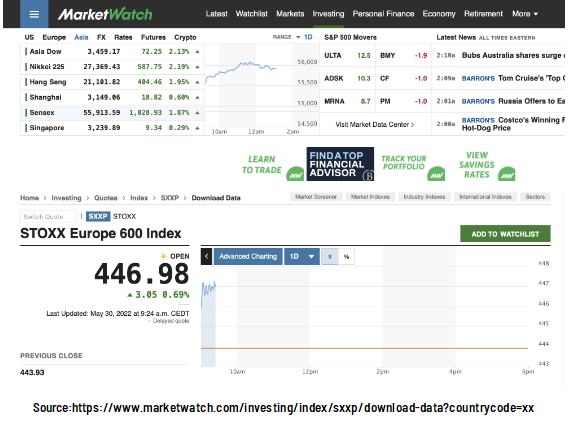

蒐集從
2016/1/1 到 2022/5/27 的 STOXX 600 指數，其中包含
開盤價、收盤價、當天最高及最低值

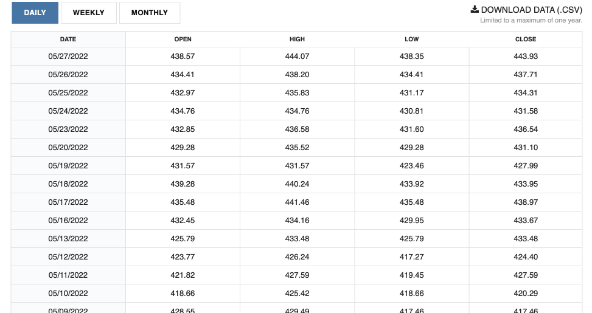

##TTF荷蘭基準天然氣價格來源

https://www.investing.com/commodities/dutch 

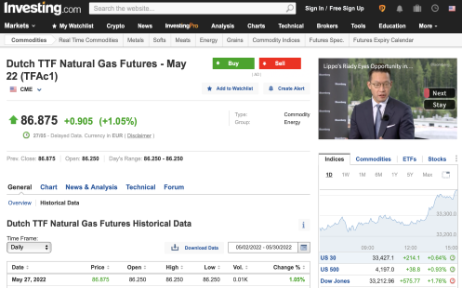

##歐盟區每日平均溫度來源

https://www.ecad.eu/dailydata/index.php

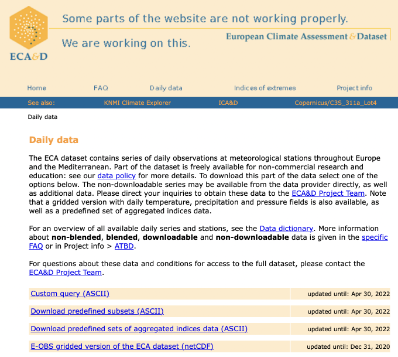

##各國出口到歐盟區的天然氣供給量

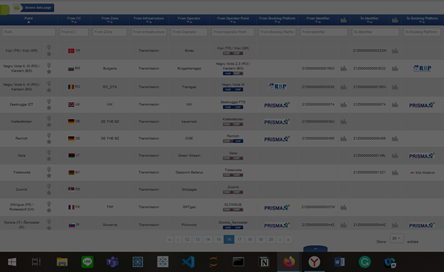

透過訪問每個邊界接收站，
來獲取每條管道天然氣的運
輸量 譬如在敦克爾克接收站
可以複製出挪威輸入法國的
天然氣供應量，在維堡可以
收集出俄羅斯輸送至芬蘭的
供應量 。
而國家總出口量則透過加總
的方式 ( 亞瑪爾歐洲管道
北溪 1 號 土耳其溪 烏克蘭利
沃夫管道 俄羅斯對歐運輸
量

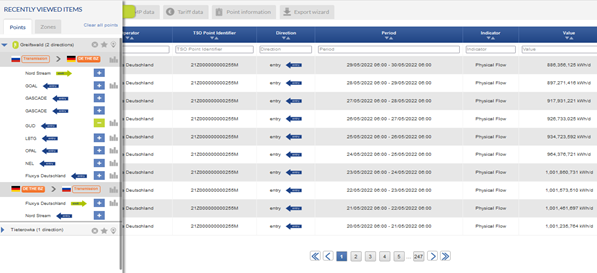

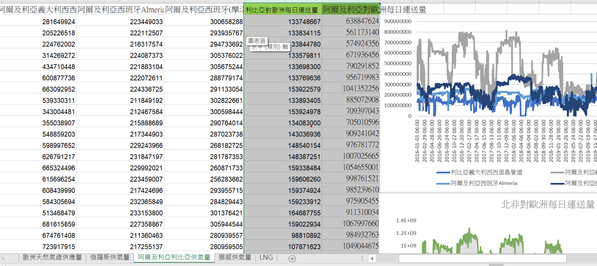

上面的這些資料蒐集可以透過爬蟲或更省力的方式實現，但我們用最人工的方式慢慢抓QQ

#2.引入套件

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt

import seaborn as sns       ###畫關係圖用的

from numpy                 import array
from sklearn               import metrics
from sklearn.preprocessing import StandardScaler  ##最小最大值標準化
from tensorflow.keras.models          import Sequential #建造我們的深度學習模型用
from tensorflow.keras.layers          import LSTM
from tensorflow.keras.layers import Dense, Dropout


#3.引入共用雲端硬碟資料

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ttf= pd.read_csv('/content/drive/MyDrive/軟體應用資料庫/TTF價格.csv')
stoxx = pd.read_csv("/content/drive/MyDrive/軟體應用資料庫/STOXX600.csv")
temperature = pd.read_csv("/content/drive/MyDrive/軟體應用資料庫/歐盟區每日均溫(1).csv")
ng = pd.read_csv("/content/drive/MyDrive/軟體應用資料庫/天然氣價格專題資料庫.csv")
inventory = pd.read_csv("/content/drive/MyDrive/軟體應用資料庫/天然氣庫存量.csv")

荷蘭歐洲基準天然氣價格

> 當日開盤價、明天開盤價、一周後開盤價



In [4]:
ttf["TTF open Price"].tail(3)


1154    94.540
1155    91.025
1156    87.900
Name: TTF open Price, dtype: float64

歐盟STOXX600指數(歐洲股票市場)

In [5]:
stoxx.head(3)

,Date,stoxx600 open price,stoxx600 hight price,stoxx600 low price,stoxx600 close price
0,2017/10/23,390.65,391.59,389.80,390.74
1,2017/10/24,390.44,391.31,389.14,389.33
2,2017/10/25,388.98,390.52,386.74,387.13


各國對歐洲天然氣每日管道供氣量以及海運天然氣進口量(LNG)



In [6]:
ng.head(3)

,Date,Netherlands,Denmark,Romania,Azerbaijan,Norway,Libya,Algeria,Russia,LNG,Total NG import
0,2017/10/23,1329457482,119096184,296829999,0,2596220092,165014298,1043858558,5271528712,1046225255,11868230579
1,2017/10/24,1215090646,120761601,307311956,0,2611223227,170618171,1011284428,5398808316,1124810069,11959908413
2,2017/10/25,1261014177,105042649,294843916,0,2646759000,159738839,999165318,5543113991,1087258056,12096935946


歐洲各國每日平均氣溫以及全歐洲平均溫度



In [7]:
temperature.head(3)

,Date,SWEDEN (STAID: 8),NETHERLANDS (STAID: 160),POLAND (STAID: 752),LATVIA (STAID: 986),UNITED KINGDOM (STAID: 1842),ITALY (STAID: 169),AUSTRIA (STAID: 14),SLOVENIA (STAID: 3328),SPAIN (STAID: 3839),...,IRELAND (STAID: 3553),LUXEMBOURG (STAID: 203),PORTUGAL (STAID: 214),ROMANIA (STAID: 219),SLOVAKIA (STAID: 3542),BULGARIA,LITHUANIA,GREECE,MALTA,AVG.(celsius)
0,2017/10/23,0.9,12.6,7.3,-0.6,10.7,13.7,8.0,8.1,14.8,...,11.8,8.8,19.1,13.0,9.5,12.2,3.4,5.6,6.8,9.32
1,2017/10/24,1.0,15.3,5.1,-2.1,15.1,14.6,9.9,9.8,16.6,...,11.6,11.7,20.2,11.9,6.5,10.6,3.4,5.6,6.6,9.98
2,2017/10/25,1.3,14.1,6.7,-2.0,15.2,11.0,13.2,8.7,17.0,...,10.8,13.1,19.1,7.1,8.2,8.3,3.6,5.4,6.7,9.93


歐洲天然氣每日庫存量

In [8]:
inventory.head(3)

,Date,Gas in storage (TWh)
0,2022/5/20,464.3356
1,2022/5/19,459.3359
2,2022/5/18,454.6235


# 4.視覺化我們的資料

<ipython-input-9-37afa7f5a804>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


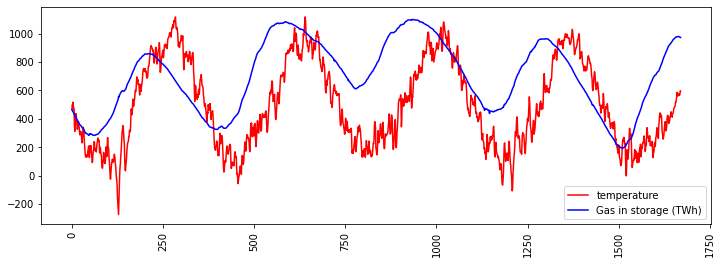

In [9]:
fig=plt.figure(figsize=(12,4))
plt.xticks(rotation = 90)  
ax1 = fig.add_subplot(111)
ax1.plot(50*temperature["AVG.(celsius)"],color='red',label='temperature')
ax1.plot(inventory["Gas in storage (TWh)"],color='blue',label='Gas in storage (TWh)')
plt.legend()

從上面這張圖片，我們可以看出，天氣越冷，可能暖氣與用電量就越大，造成天然氣使用增加，庫存減少

<ipython-input-10-bd28ba03dcda>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot(111)


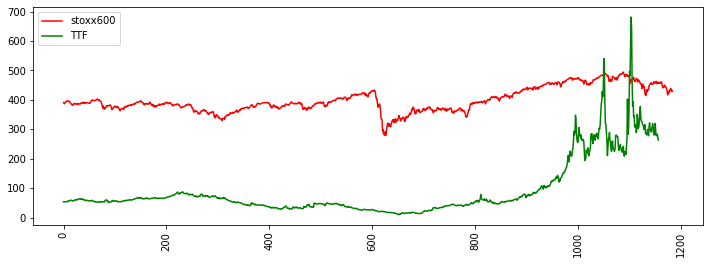

In [10]:
fig=plt.figure(figsize=(12,4))
plt.xticks(rotation = 90)  
ax1 = fig.add_subplot(111)
ax1.plot(stoxx["stoxx600 close price"],color='red',label='stoxx600')
ax1.plot(3*ttf["TTF open Price"],color='green',label='TTF')
plt.legend()

從上面這張圖可以看出歐洲股市趨勢和天然氣有一點關係，而在2021年天然氣價格劇烈成長

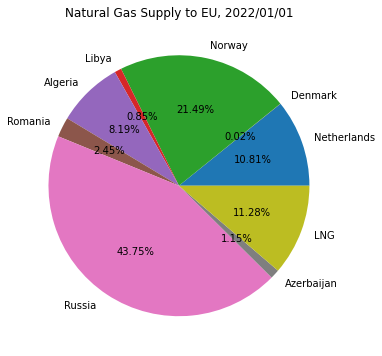

In [11]:
fig=plt.figure(figsize=(12,6))
df_ng = pd.DataFrame([
    ['Netherlands', 1107782303], ['Denmark', 2061335],['Norway ', 2202261266],  ['Libya', 87609563], ['Algeria', 839599887], ['Romania', 251520573],
    ['Russia ', 4483988094],  ['Azerbaijan', 117924938 ], ['LNG', 1155836752]],columns=['country', 'supply'])
plt.pie(df_ng['supply'], labels=df_ng['country'], autopct='%1.2f%%')
plt.title('Natural Gas Supply to EU, 2022/01/01')
plt.show()

從上面這張圖可以看到，歐洲天然氣將近四成來自俄爹，兩成來自挪威，一成來自LNG(海運液化天然氣，主要來自美國跟卡達)

#5.資料整理

合併資料，df為最終合併的資料
日期排列相反的委全部統一，以天然氣的日期當基準(2017-2022)

In [12]:
df0 = pd.merge(ng, inventory,on="Date",how="outer")
df1 = pd.merge(df0, temperature,on="Date",how="outer")
df2 = pd.merge(df1, stoxx,on="Date",how="outer")
df = pd.merge(df2, ttf,on="Date",how="outer")

檢查資料有沒有空值，發現假日或節日ttf跟stoxx沒有開盤，所以資料空白

In [13]:
df.isnull().sum()

Date                              1
Netherlands                       2
Denmark                           2
Romania                           2
Azerbaijan                        2
Norway                            2
Libya                             2
Algeria                           2
Russia                            2
LNG                               2
Total NG import                   2
Gas in storage (TWh)              2
 SWEDEN (STAID: 8)                2
 NETHERLANDS (STAID: 160)         2
 POLAND (STAID: 752)              2
 LATVIA (STAID: 986)              2
UNITED KINGDOM (STAID: 1842)      2
 ITALY (STAID: 169)               2
 AUSTRIA (STAID: 14)              2
 SLOVENIA (STAID: 3328)           2
 SPAIN (STAID: 3839)              2
 GERMANY (STAID: 4932)            2
 ESTONIA (STAID: 11364)           2
 FINLAND (STAID: 7723)            2
 BELGIUM (STAID: 21787)           2
 CROATIA (STAID: 1683)            2
 CYPRUS (STAID: 24)               2
CZECH REPUBLIC(STAID: 27)   

我們把資料補齊，可以選擇補0或補平均數，
但我們以前值代替(假日資料用週五代替)

In [14]:
df = df.fillna(method='ffill')

補齊後的資料展現

In [15]:
df.head(4)

,Date,Netherlands,Denmark,Romania,Azerbaijan,Norway,Libya,Algeria,Russia,LNG,...,GREECE,MALTA,AVG.(celsius),stoxx600 open price,stoxx600 hight price,stoxx600 low price,stoxx600 close price,TTF open Price,TTF open Price t+1,TTF open Price t+7
0,2017/10/23,1.329457e+09,119096184.0,296829999.0,0.0,2.596220e+09,165014298.0,1.043859e+09,5.271529e+09,1.046225e+09,...,5.6,6.8,9.32,390.65,391.59,389.80,390.74,18.09,17.96,18.110
1,2017/10/24,1.215091e+09,120761601.0,307311956.0,0.0,2.611223e+09,170618171.0,1.011284e+09,5.398808e+09,1.124810e+09,...,5.6,6.6,9.98,390.44,391.31,389.14,389.33,17.96,18.11,18.285
2,2017/10/25,1.261014e+09,105042649.0,294843916.0,0.0,2.646759e+09,159738839.0,9.991653e+08,5.543114e+09,1.087258e+09,...,5.4,6.7,9.93,388.98,390.52,386.74,387.13,18.11,18.07,18.550
3,2017/10/26,1.300023e+09,48761826.0,295346611.0,0.0,2.281452e+09,159778835.0,9.816894e+08,5.522241e+09,9.741236e+08,...,5.7,6.6,10.35,387.02,391.45,386.44,391.27,18.07,18.15,18.580


檢查還剩多少缺漏，沒了，很好

In [16]:
df.isnull().sum()

Date                            0
Netherlands                     0
Denmark                         0
Romania                         0
Azerbaijan                      0
Norway                          0
Libya                           0
Algeria                         0
Russia                          0
LNG                             0
Total NG import                 0
Gas in storage (TWh)            0
 SWEDEN (STAID: 8)              0
 NETHERLANDS (STAID: 160)       0
 POLAND (STAID: 752)            0
 LATVIA (STAID: 986)            0
UNITED KINGDOM (STAID: 1842)    0
 ITALY (STAID: 169)             0
 AUSTRIA (STAID: 14)            0
 SLOVENIA (STAID: 3328)         0
 SPAIN (STAID: 3839)            0
 GERMANY (STAID: 4932)          0
 ESTONIA (STAID: 11364)         0
 FINLAND (STAID: 7723)          0
 BELGIUM (STAID: 21787)         0
 CROATIA (STAID: 1683)          0
 CYPRUS (STAID: 24)             0
CZECH REPUBLIC(STAID: 27)       0
 DENMARK (STAID: 116)           0
 FRANCE (STAID

檢查相關係數

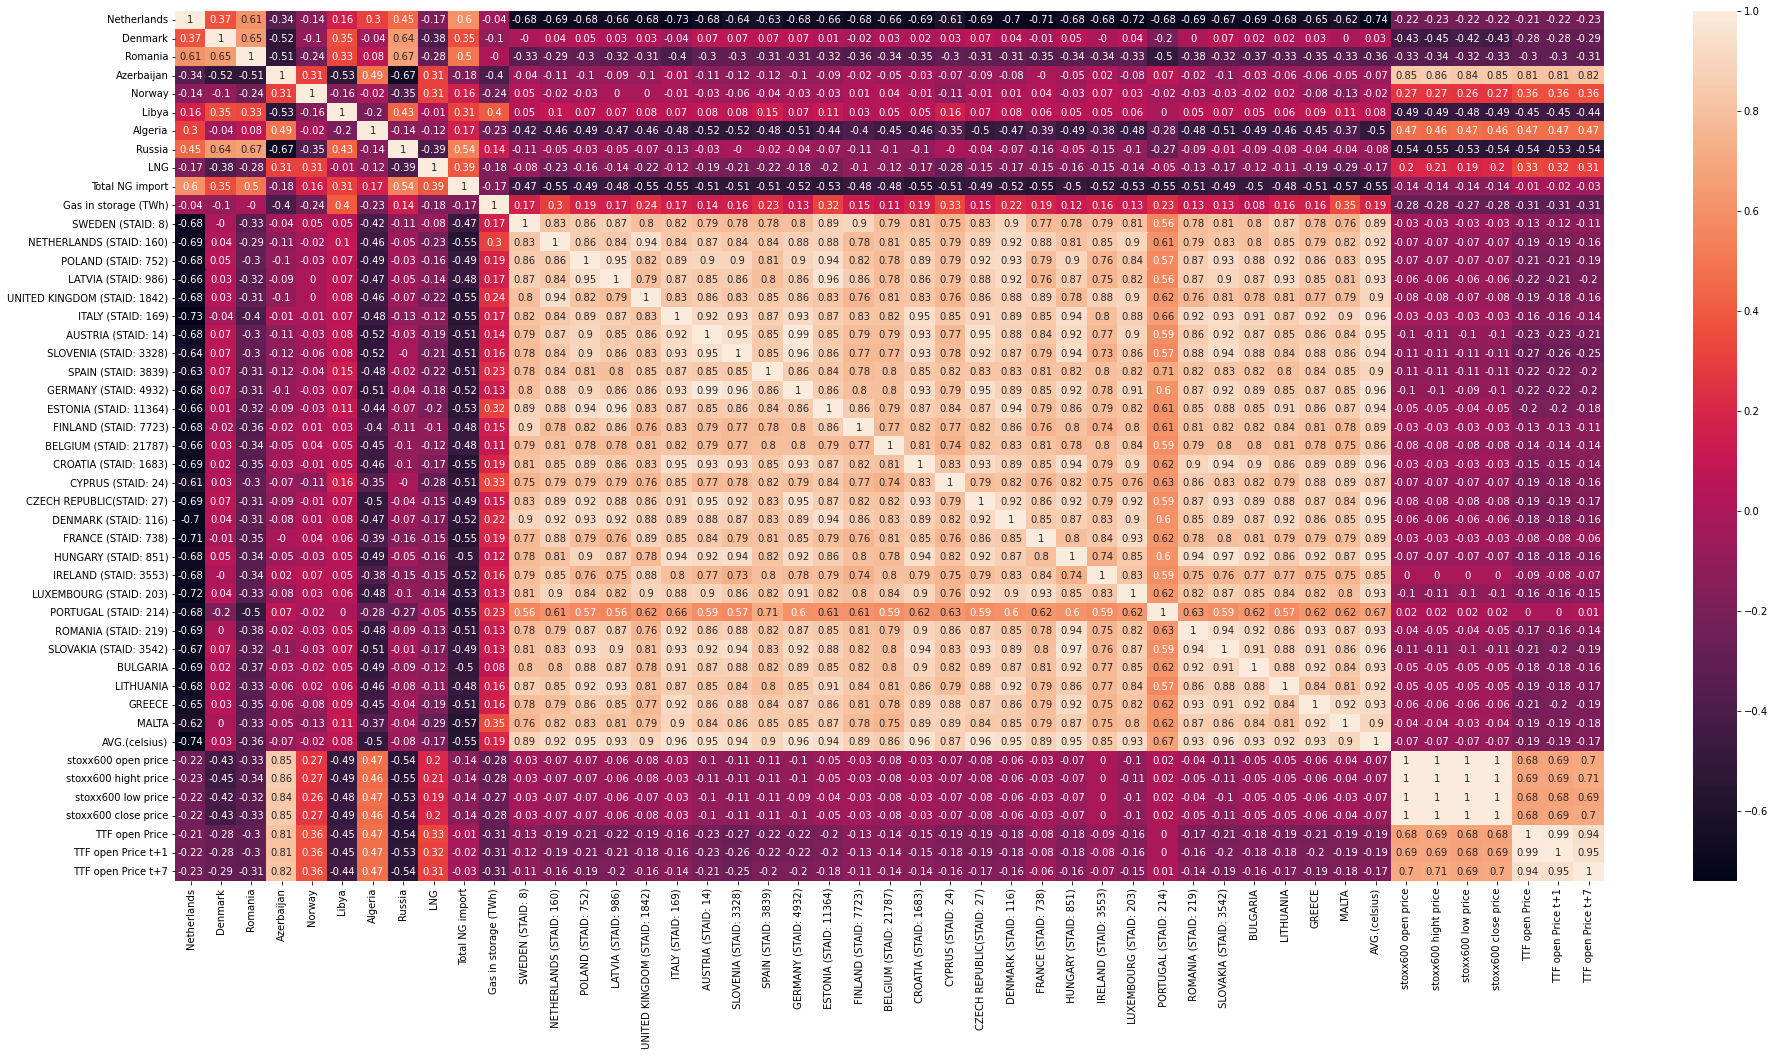

In [17]:
correlation_matrix = df.corr().round(2)
# annot = True 讓我們可以把數字標進每個格子裡
plt.figure(figsize=(32,16))
sns.heatmap(data=correlation_matrix, annot = True)
plt.show()

從上面這張圖可以看到，
TTF天然氣價格跟STOXX600相關性達到0.68
跟亞塞拜然的天然氣進口量相關性達到0.81
跟挪威以及阿爾及利亞正相關，
跟俄羅斯出口量、利比亞出口量、歐洲庫存量是負相關

我們可以解讀為，俄羅斯因為政治目的減少天然氣出口量，以及利比亞因為戰亂減少天然氣供給，都有可能造成天然氣價格提升

而為了遏止天然氣價格提升，挪威跟阿爾及利亞努力增產，滿足歐盟區的需要

從上面這張圖也可以看到，天氣不是影響天然氣價格的主要因素

我們繼續檢查一下每個資料的型態

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1673 entries, 0 to 1672
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          1673 non-null   object 
 1   Netherlands                   1673 non-null   float64
 2   Denmark                       1673 non-null   float64
 3   Romania                       1673 non-null   float64
 4   Azerbaijan                    1673 non-null   float64
 5   Norway                        1673 non-null   float64
 6   Libya                         1673 non-null   float64
 7   Algeria                       1673 non-null   float64
 8   Russia                        1673 non-null   float64
 9   LNG                           1673 non-null   float64
 10  Total NG import               1673 non-null   float64
 11  Gas in storage (TWh)          1673 non-null   float64
 12   SWEDEN (STAID: 8)            1673 non-null   float64
 13   NE

把日期分割走，不想把它放到我們的預測模型

In [19]:
time_df = pd.to_datetime(df['Date'])
time_df.head(4)

0   2017-10-23
1   2017-10-24
2   2017-10-25
3   2017-10-26
Name: Date, dtype: datetime64[ns]

我們選擇十一個比較相關的變量當我們的預測資料

In [20]:
df_input=df[['Azerbaijan','Russia','Norway','Algeria',"Libya",'LNG','Gas in storage (TWh)','stoxx600 open price',
                      'stoxx600 hight price', 'stoxx600 low price','TTF open Price']]
df_input.head(4)

,Azerbaijan,Russia,Norway,Algeria,Libya,LNG,Gas in storage (TWh),stoxx600 open price,stoxx600 hight price,stoxx600 low price,TTF open Price
0,0.0,5.271529e+09,2.596220e+09,1.043859e+09,165014298.0,1.046225e+09,972.2294,390.65,391.59,389.80,18.09
1,0.0,5.398808e+09,2.611223e+09,1.011284e+09,170618171.0,1.124810e+09,973.2073,390.44,391.31,389.14,17.96
2,0.0,5.543114e+09,2.646759e+09,9.991653e+08,159738839.0,1.087258e+09,974.6381,388.98,390.52,386.74,18.11
3,0.0,5.522241e+09,2.281452e+09,9.816894e+08,159778835.0,9.741236e+08,975.3117,387.02,391.45,386.44,18.07


我們把每個數據做標準化，用transform的原因是因為後面做預測時可以再把標準化的資料還原




In [21]:
ss = StandardScaler()
df_ss = ss.fit_transform(df_input)

X是輸入的資料，每天有11種因素(各國輸入量...庫存..當天股市開盤價錢....當日盤中最高價與最低價...)

Y是輸出資料，只有一種，就是明日早上開盤天然氣價格

而我們想用每七天的資料去預測未來1天

In [22]:
Xtrain = []
Ytrain = []

future = 1   
past = 7 

別忘記我們要預測的資料是第十一個，ttf開盤價



In [23]:
for i in range(past, len(df_ss) - future +1):
    Xtrain.append(df_ss[i - past:i, 0:df_input.shape[1]])
    Ytrain.append(df_ss[i + future - 1:i + future, 10])


把X跟Y轉成array

In [24]:
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

In [25]:
Xtrain.shape

(1666, 7, 11)

1666筆資料，每七天，一天11種變量

In [26]:
Ytrain.shape

(1666, 1)

1666筆資料，預測出1天1種變量

#6.打造組裝神經網路

我們選用RNN模型的變體LSTM，作時間序列模型，
第一層有128個細胞，激發函數用relu
原本要再做一層，但發現效果沒比較好，所以我就用##加註

Dropout是預防過度擬合，最後放了一個Dense層收尾

In [27]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]), return_sequences=False)) #True
#model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.15))
model.add(Dense(Ytrain.shape[1]))

損失函數我們用MSE(Mean Squared Error)

拿預測的值(predictd value)與真實數據(labeled value)相減
所有的相減值皆平方(避免誤差正負相消)，並取總和
再除以總數量平均


In [28]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               71680     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 71,809
Trainable params: 71,809
Non-trainable params: 0
_________________________________________________________________


#7.訓練

訓練個100次

In [29]:
history = model.fit(Xtrain, Ytrain, epochs=100, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/100
12/12 [==============================] - 4s 36ms/step - loss: 0.1931 - val_loss: 1.9136
Epoch 2/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0406 - val_loss: 1.7756
Epoch 3/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0301 - val_loss: 1.8721
Epoch 4/100
12/12 [==============================] - 0s 15ms/step - loss: 0.0205 - val_loss: 1.8157
Epoch 5/100
12/12 [==============================] - 0s 17ms/step - loss: 0.0146 - val_loss: 1.3981
Epoch 6/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0155 - val_loss: 1.4221
Epoch 7/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0127 - val_loss: 1.5411
Epoch 8/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0118 - val_loss: 1.5244
Epoch 9/100
12/12 [==============================] - 0s 16ms/step - loss: 0.0107 - val_loss: 1.2701
Epoch 10/100
12/12 [==============================] - 0s 18ms/step - loss: 0.0099 - val_loss: 1.3022

成果

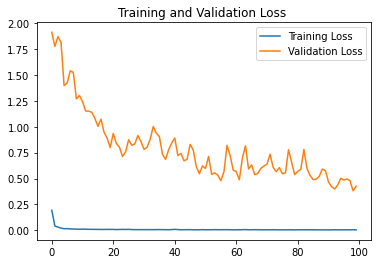

In [30]:
plt.plot(history.history['loss']    , label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss ')
plt.legend()

# 8.我們來看過去1500天跟明日的預測結果

In [31]:
past_n = 1501
predict_days_n = 1500  #let us predict past 15 days

predict_dates = pd.date_range(list(time_df)[-past_n], periods= predict_days_n).tolist()
print(predict_dates)

[Timestamp('2018-04-13 00:00:00', freq='D'), Timestamp('2018-04-14 00:00:00', freq='D'), Timestamp('2018-04-15 00:00:00', freq='D'), Timestamp('2018-04-16 00:00:00', freq='D'), Timestamp('2018-04-17 00:00:00', freq='D'), Timestamp('2018-04-18 00:00:00', freq='D'), Timestamp('2018-04-19 00:00:00', freq='D'), Timestamp('2018-04-20 00:00:00', freq='D'), Timestamp('2018-04-21 00:00:00', freq='D'), Timestamp('2018-04-22 00:00:00', freq='D'), Timestamp('2018-04-23 00:00:00', freq='D'), Timestamp('2018-04-24 00:00:00', freq='D'), Timestamp('2018-04-25 00:00:00', freq='D'), Timestamp('2018-04-26 00:00:00', freq='D'), Timestamp('2018-04-27 00:00:00', freq='D'), Timestamp('2018-04-28 00:00:00', freq='D'), Timestamp('2018-04-29 00:00:00', freq='D'), Timestamp('2018-04-30 00:00:00', freq='D'), Timestamp('2018-05-01 00:00:00', freq='D'), Timestamp('2018-05-02 00:00:00', freq='D'), Timestamp('2018-05-03 00:00:00', freq='D'), Timestamp('2018-05-04 00:00:00', freq='D'), Timestamp('2018-05-05 00:00:00'

In [32]:
prediction = model.predict(Xtrain[-predict_days_n:]) 

47/47 [==============================] - 0s 3ms/step


In [33]:
prediction_copies = np.repeat(prediction, df_input.shape[1], axis=-1)
Y_prediction_future = ss.inverse_transform(prediction_copies)[:,10]

In [34]:
forecast_dates = []
for time_i in predict_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'TTF open Price':Y_prediction_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

好像還不錯

<ipython-input-35-8dae1ccb2c39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation

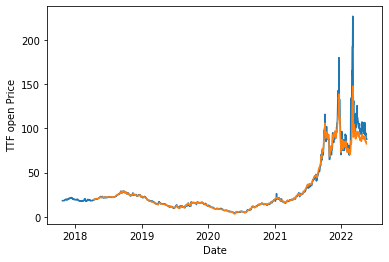

In [35]:
original = df[['Date']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2017-1-1']
sns.lineplot(original['Date'], df['TTF open Price'])
sns.lineplot(df_forecast['Date'], df_forecast['TTF open Price'])

我們來看一下最後兩天以及未來(5/21)的預測結果

In [36]:
 df_forecast.tail(3)

,Date,TTF open Price
1497,2022-05-19,85.550240
1498,2022-05-20,83.273422
1499,2022-05-21,82.534393


#實際開盤價格(我們歷史資料只到5/20)

	
#####2022/5/19 	91.025 	
#####2022/5/20 	87.900 
#####2022/5/21 	83.290

# 存檔



In [37]:

from google.colab import drive

drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks'

model.save('程式設計期末專案')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks
